## Modeling Objetives

### Introduction

After doing the data cleaning and feature selection. We have decided to test models in order to predict the ratings of a book from different inputs. One of the main transformation that were performed was the transformation of the rating columns into 3 different categories. 
It would be interesting too to compare models that predict the initial average rating, when using SMOTE algorithm in order to balance the data.

## Steps to follow

 #### 1. Feature analysis and selection

Perform data analysis of each variable and check correlations
Make comparison between cleaned data and its original counter-part
Check the effect of data transformation on the distributions
Select best data for ML algorithms, 
Decide about inputs and target 

#### 2. Model Selection and Testing

We check the performance of several models that 

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
cleaned_data = pd.read_excel('Projet Python simulations.xlsx', sheet_name="Excel for Python simulations")
ori_data = pd.read_csv('books.csv', encoding='UTF-8',on_bad_lines='skip')

In [ ]:
ori_data.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', '  num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

In [ ]:
ori_data.columns
ori_data = ori_data[['isbn','title', 'average_rating','language_code','  num_pages','ratings_count','text_reviews_count','publication_date','publisher','authors']]

ori_data['publication_date'] = pd.to_datetime(ori_data['publication_date'], format='%m/%d/%Y', errors="coerce")
ori_data.at[8177,'publication_date']='11/30/2000'
ori_data.at[11094,'publication_date']= '6/30/1982'


In [ ]:
ori_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   isbn                11123 non-null  object        
 1   title               11123 non-null  object        
 2   average_rating      11123 non-null  float64       
 3   language_code       11123 non-null  object        
 4     num_pages         11123 non-null  int64         
 5   ratings_count       11123 non-null  int64         
 6   text_reviews_count  11123 non-null  int64         
 7   publication_date    11123 non-null  datetime64[ns]
 8   publisher           11123 non-null  object        
 9   authors             11123 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 869.1+ KB


## 1. Feature Analysis and Selection

The columns we have chosen and their original counterparts are the following:

1. title = title
2. rating_category = average_rating
3. language_number = language_code
4. num_pages (categorical) = num_pages (discrete)
5. ratings_count (categorical) = ratings_count(discrete)
6. text_reviews_counts (categorical) = text_reviews_count (discrete)
7. season = publication_date
8. year = publication_date
9. Publisher_number= publisher
10. Main_author (numerical) = authors
*Author_average has no original and is calculated as the average_ratings of the author that has been transformed as categorical data


In [ ]:
cleaned_data.columns

dictionary = {'num_pages' : 'num_pages_cat',
              'ratings_count' : 'ratings_count_cat',
              'text_reviews_count' : 'text_reviews_count_cat'
              }

In [ ]:
control_dataset_columns = ['isbn','average_rating', '  num_pages', 'ratings_count','text_reviews_count','publication_date']
excel_dataset_columns = ['isbn', 'rating_category', 'num_pages', 'ratings_count', 'text_reviews_count', 'Season','Year']
feature_eng_dataset_columns = ['isbn','average_rating', 'rating_category', 'num_pages_cat', '  num_pages', 'ratings_count_cat', 'ratings_count', 'text_reviews_count_cat', 'text_reviews_count', 'Season','Year']

In [ ]:
cleaned_data = cleaned_data[excel_dataset_columns]
cleaned_data = cleaned_data.rename(columns=dictionary)


In [ ]:
ori_data = ori_data[control_dataset_columns]

In [ ]:
ori_data
merged_data = pd.merge(ori_data, cleaned_data, how="inner", on=["isbn"])
featured_eng_dataset = merged_data[feature_eng_dataset_columns]

In [ ]:
featured_eng_dataset


,isbn,average_rating,rating_category,num_pages_cat,num_pages,ratings_count_cat,ratings_count,text_reviews_count_cat,text_reviews_count,Season,Year
0,0439785960,4.57,3,3,652,3,2095690,3,27591,4,2006
1,0439358078,4.49,3,3,870,3,2153167,3,29221,4,2004
2,043965548X,4.56,3,3,435,3,2339585,3,36325,2,2004
3,0439682584,4.78,3,3,2690,3,41428,3,164,4,2004
4,0976540606,3.74,2,1,152,1,19,1,1,2,2005
...,...,...,...,...,...,...,...,...,...,...,...
10306,1560254416,4.06,2,3,512,1,156,2,20,1,2004
10307,0140110879,4.08,2,3,635,2,783,2,56,1,1988
10308,0140131965,3.96,2,3,415,2,820,2,95,3,1993
10309,0060878827,3.72,2,3,434,2,769,2,139,1,2007


In [ ]:
featured_eng_dataset = pd.concat([featured_eng_dataset, pd.get_dummies(featured_eng_dataset['rating_category'], prefix="rat_cat", prefix_sep='_')], axis=1).drop(columns="rating_category")
featured_eng_dataset = pd.concat([featured_eng_dataset, pd.get_dummies(featured_eng_dataset['num_pages_cat'], prefix="np_cat", prefix_sep='_')], axis=1).drop(columns="num_pages_cat")
featured_eng_dataset = pd.concat([featured_eng_dataset, pd.get_dummies(featured_eng_dataset['ratings_count_cat'], prefix="rcount_cat", prefix_sep='_')], axis=1).drop(columns="ratings_count_cat")
featured_eng_dataset = pd.concat([featured_eng_dataset, pd.get_dummies(featured_eng_dataset['text_reviews_count_cat'], prefix="tr_count", prefix_sep='_')], axis=1).drop(columns="text_reviews_count_cat")
featured_eng_dataset = pd.concat([featured_eng_dataset, pd.get_dummies(featured_eng_dataset['Season'], prefix="season", prefix_sep='_')], axis=1).drop(columns="Season")


In [ ]:
featured_eng_dataset = pd.concat([featured_eng_dataset, pd.get_dummies(featured_eng_dataset['Season'], prefix="season", prefix_sep='_')], axis=1).drop(columns="Season")

KeyError: 'Season'

In [ ]:
featured_eng_dataset = featured_eng_dataset.drop(columns="isbn")

In [ ]:
featured_eng_dataset

,average_rating,num_pages,ratings_count,text_reviews_count,Year,rat_cat_1,rat_cat_2,rat_cat_3,np_cat_1,np_cat_2,...,rcount_cat_1,rcount_cat_2,rcount_cat_3,tr_count_1,tr_count_2,tr_count_3,season_1,season_2,season_3,season_4
0,4.57,652,2095690,27591,2006,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,4.49,870,2153167,29221,2004,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
2,4.56,435,2339585,36325,2004,0,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
3,4.78,2690,41428,164,2004,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
4,3.74,152,19,1,2005,0,1,0,1,0,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10306,4.06,512,156,20,2004,0,1,0,0,0,...,1,0,0,0,1,0,1,0,0,0
10307,4.08,635,783,56,1988,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0
10308,3.96,415,820,95,1993,0,1,0,0,0,...,0,1,0,0,1,0,0,0,1,0
10309,3.72,434,769,139,2007,0,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0


In [ ]:
ori_data = ori_data[control_dataset_columns]
#cleaned_data = cleaned_data[feature_eng_dataset_columns]

In [ ]:
display(featured_eng_dataset.head())
display(featured_eng_dataset.info())
featured_eng_dataset.describe()

,isbn,average_rating,num_pages,ratings_count,text_reviews_count,Year,rat_cat_1,rat_cat_2,rat_cat_3,np_cat_1,...,rcount_cat_1,rcount_cat_2,rcount_cat_3,tr_count_1,tr_count_2,tr_count_3,season_1,season_2,season_3,season_4
0,0439785960,4.57,652,2095690,27591,2006,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
1,0439358078,4.49,870,2153167,29221,2004,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
2,043965548X,4.56,435,2339585,36325,2004,0,0,1,0,...,0,0,1,0,0,1,0,1,0,0
3,0439682584,4.78,2690,41428,164,2004,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
4,0976540606,3.74,152,19,1,2005,0,1,0,1,...,1,0,0,1,0,0,0,1,0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10311 entries, 0 to 10310
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   isbn                10311 non-null  object 
 1   average_rating      10311 non-null  float64
 2     num_pages         10311 non-null  int64  
 3   ratings_count       10311 non-null  int64  
 4   text_reviews_count  10311 non-null  int64  
 5   Year                10311 non-null  int64  
 6   rat_cat_1           10311 non-null  uint8  
 7   rat_cat_2           10311 non-null  uint8  
 8   rat_cat_3           10311 non-null  uint8  
 9   np_cat_1            10311 non-null  uint8  
 10  np_cat_2            10311 non-null  uint8  
 11  np_cat_3            10311 non-null  uint8  
 12  rcount_cat_1        10311 non-null  uint8  
 13  rcount_cat_2        10311 non-null  uint8  
 14  rcount_cat_3        10311 non-null  uint8  
 15  tr_count_1          10311 non-null  uint8  
 16  tr_c

None

,average_rating,num_pages,ratings_count,text_reviews_count,Year,rat_cat_1,rat_cat_2,rat_cat_3,np_cat_1,np_cat_2,...,rcount_cat_1,rcount_cat_2,rcount_cat_3,tr_count_1,tr_count_2,tr_count_3,season_1,season_2,season_3,season_4
count,10311.000000,10311.000000,1.031100e+04,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,...,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000
mean,3.933302,334.382698,1.926855e+04,578.359616,2000.214819,0.086316,0.672583,0.241102,0.333139,0.328775,...,0.329260,0.340607,0.330133,0.326641,0.342935,0.330424,0.412666,0.244593,0.226651,0.116090
std,0.357353,238.634519,1.167088e+05,2671.914308,8.157561,0.280843,0.469294,0.427773,0.471359,0.469791,...,0.469967,0.473936,0.470284,0.469008,0.474713,0.470389,0.492338,0.429867,0.418685,0.320348
min,0.000000,0.000000,0.000000e+00,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.770000,194.000000,1.120000e+02,9.000000,1998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,296.000000,8.660000e+02,51.000000,2003.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,410.500000,5.765500e+03,263.500000,2005.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
display(ori_data.head())
display(ori_data.info())
ori_data.describe()

,isbn,average_rating,num_pages,ratings_count,text_reviews_count,publication_date
0,0439785960,4.57,652,2095690,27591,2006-09-16
1,0439358078,4.49,870,2153167,29221,2004-09-01
2,0439554896,4.42,352,6333,244,2003-11-01
3,043965548X,4.56,435,2339585,36325,2004-05-01
4,0439682584,4.78,2690,41428,164,2004-09-13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   isbn                11123 non-null  object        
 1   average_rating      11123 non-null  float64       
 2     num_pages         11123 non-null  int64         
 3   ratings_count       11123 non-null  int64         
 4   text_reviews_count  11123 non-null  int64         
 5   publication_date    11123 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 521.5+ KB


None

,average_rating,num_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000
mean,3.934075,336.405556,1.794285e+04,542.048099
std,0.350485,241.152626,1.124992e+05,2576.619589
min,0.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,192.000000,1.040000e+02,9.000000
50%,3.960000,299.000000,7.450000e+02,47.000000
75%,4.140000,416.000000,5.000500e+03,238.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000


array([[<AxesSubplot: xlabel='average_rating', ylabel='average_rating'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='average_rating'>,
        <AxesSubplot: xlabel='ratings_count', ylabel='average_rating'>,
        <AxesSubplot: xlabel='text_reviews_count', ylabel='average_rating'>,
        <AxesSubplot: xlabel='Year', ylabel='average_rating'>,
        <AxesSubplot: xlabel='rat_cat_1', ylabel='average_rating'>,
        <AxesSubplot: xlabel='rat_cat_2', ylabel='average_rating'>,
        <AxesSubplot: xlabel='rat_cat_3', ylabel='average_rating'>,
        <AxesSubplot: xlabel='np_cat_1', ylabel='average_rating'>,
        <AxesSubplot: xlabel='np_cat_2', ylabel='average_rating'>,
        <AxesSubplot: xlabel='np_cat_3', ylabel='average_rating'>,
        <AxesSubplot: xlabel='rcount_cat_1', ylabel='average_rating'>,
        <AxesSubplot: xlabel='rcount_cat_2', ylabel='average_rating'>,
        <AxesSubplot: xlabel='rcount_cat_3', ylabel='average_rating'>,
        <AxesSubplot: xlabe

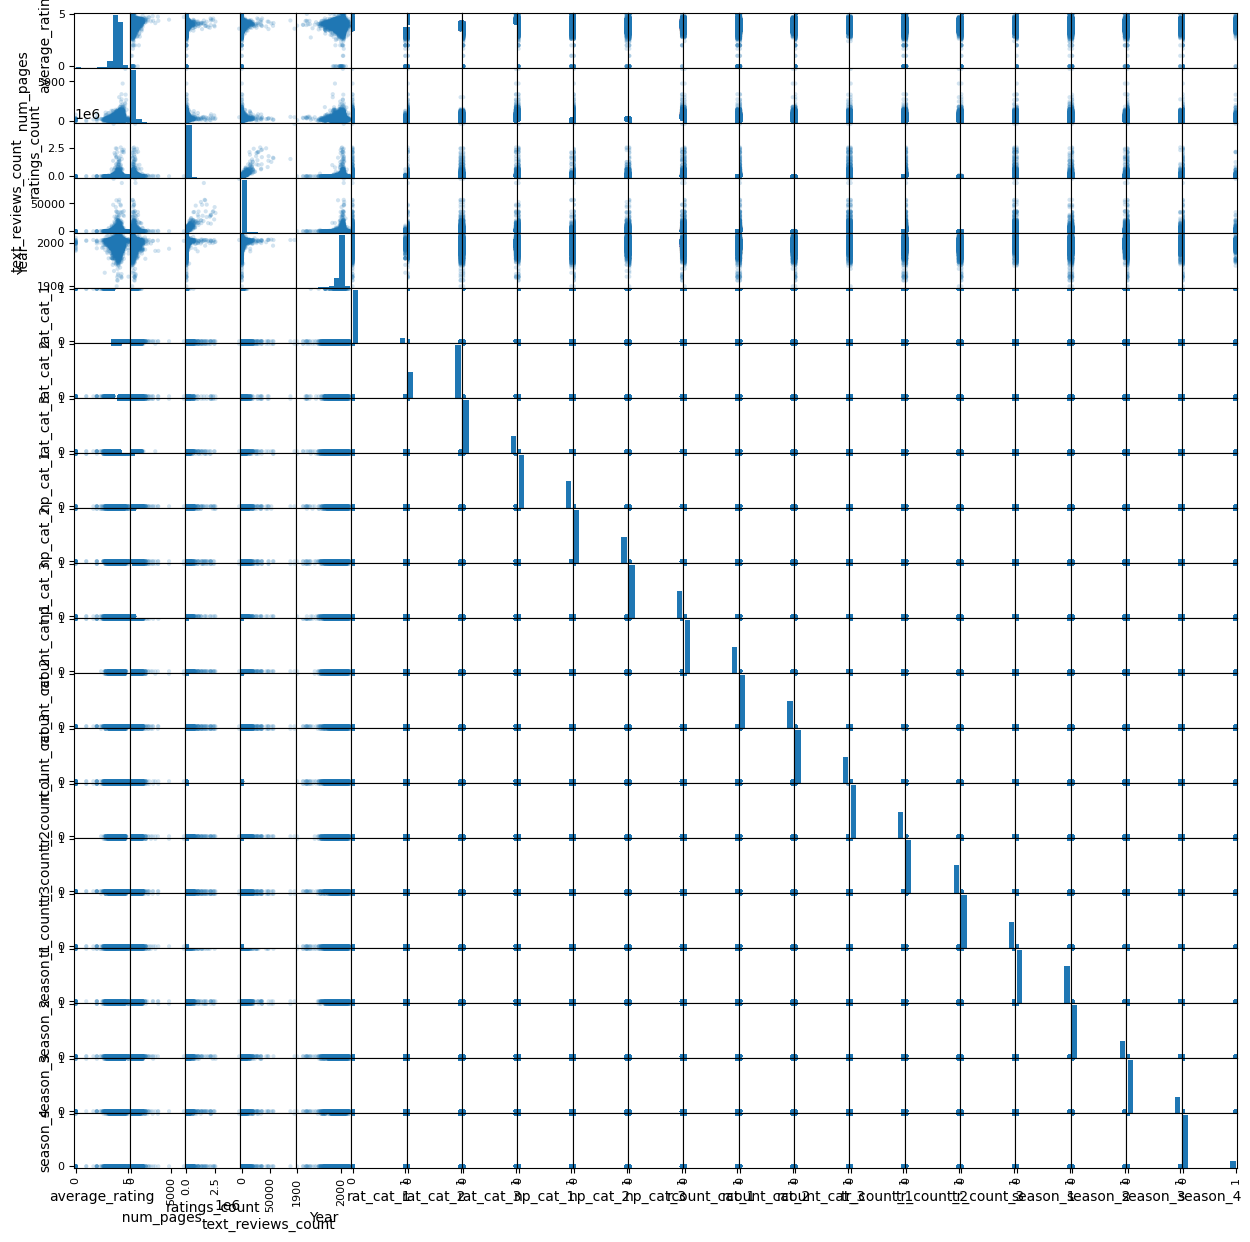

In [ ]:
# Visualise covariates two by two
from pandas.plotting import scatter_matrix
scatter_matrix(featured_eng_dataset, alpha=0.2, figsize=(15, 15))


array([[<AxesSubplot: xlabel='average_rating', ylabel='average_rating'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='average_rating'>,
        <AxesSubplot: xlabel='ratings_count', ylabel='average_rating'>,
        <AxesSubplot: xlabel='text_reviews_count', ylabel='average_rating'>],
       [<AxesSubplot: xlabel='average_rating', ylabel='  num_pages'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='  num_pages'>,
        <AxesSubplot: xlabel='ratings_count', ylabel='  num_pages'>,
        <AxesSubplot: xlabel='text_reviews_count', ylabel='  num_pages'>],
       [<AxesSubplot: xlabel='average_rating', ylabel='ratings_count'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='ratings_count'>,
        <AxesSubplot: xlabel='ratings_count', ylabel='ratings_count'>,
        <AxesSubplot: xlabel='text_reviews_count', ylabel='ratings_count'>],
       [<AxesSubplot: xlabel='average_rating', ylabel='text_reviews_count'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='text_rev

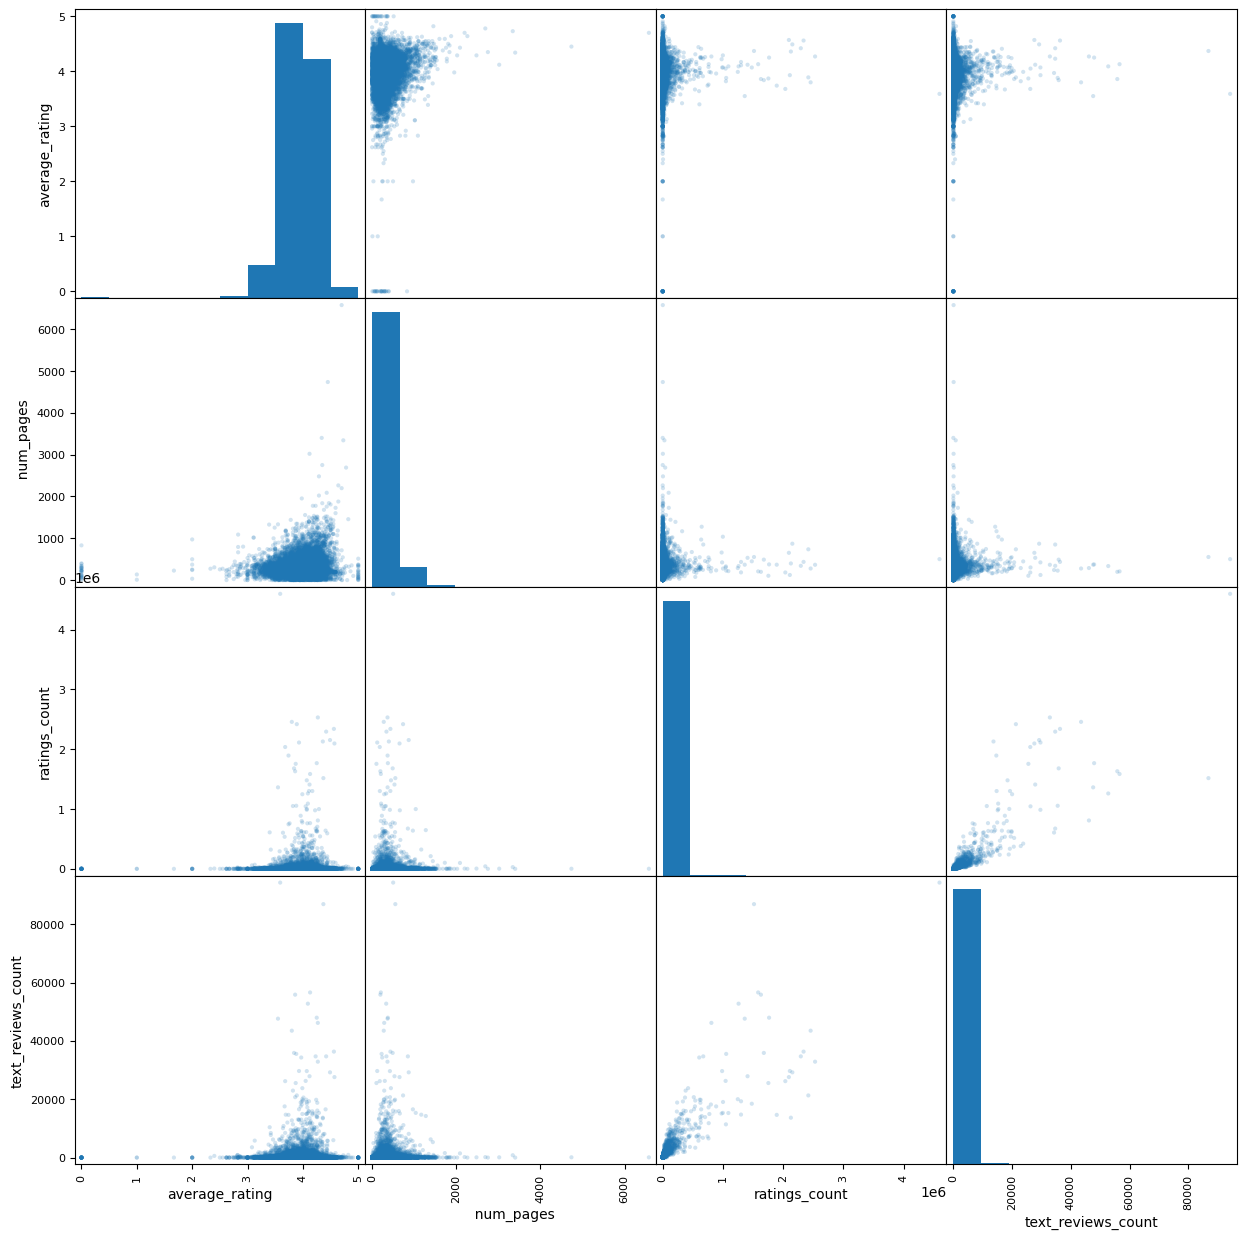

In [ ]:
# Visualise covariates two by two
from pandas.plotting import scatter_matrix
scatter_matrix(ori_data, alpha=0.2, figsize=(15, 15))


array([[<AxesSubplot: xlabel='rating_category', ylabel='rating_category'>,
        <AxesSubplot: xlabel='num_pages_cat', ylabel='rating_category'>,
        <AxesSubplot: xlabel='ratings_count_cat', ylabel='rating_category'>,
        <AxesSubplot: xlabel='text_reviews_count_cat', ylabel='rating_category'>,
        <AxesSubplot: xlabel='Season', ylabel='rating_category'>,
        <AxesSubplot: xlabel='Year', ylabel='rating_category'>],
       [<AxesSubplot: xlabel='rating_category', ylabel='num_pages_cat'>,
        <AxesSubplot: xlabel='num_pages_cat', ylabel='num_pages_cat'>,
        <AxesSubplot: xlabel='ratings_count_cat', ylabel='num_pages_cat'>,
        <AxesSubplot: xlabel='text_reviews_count_cat', ylabel='num_pages_cat'>,
        <AxesSubplot: xlabel='Season', ylabel='num_pages_cat'>,
        <AxesSubplot: xlabel='Year', ylabel='num_pages_cat'>],
       [<AxesSubplot: xlabel='rating_category', ylabel='ratings_count_cat'>,
        <AxesSubplot: xlabel='num_pages_cat', ylabel='ratin

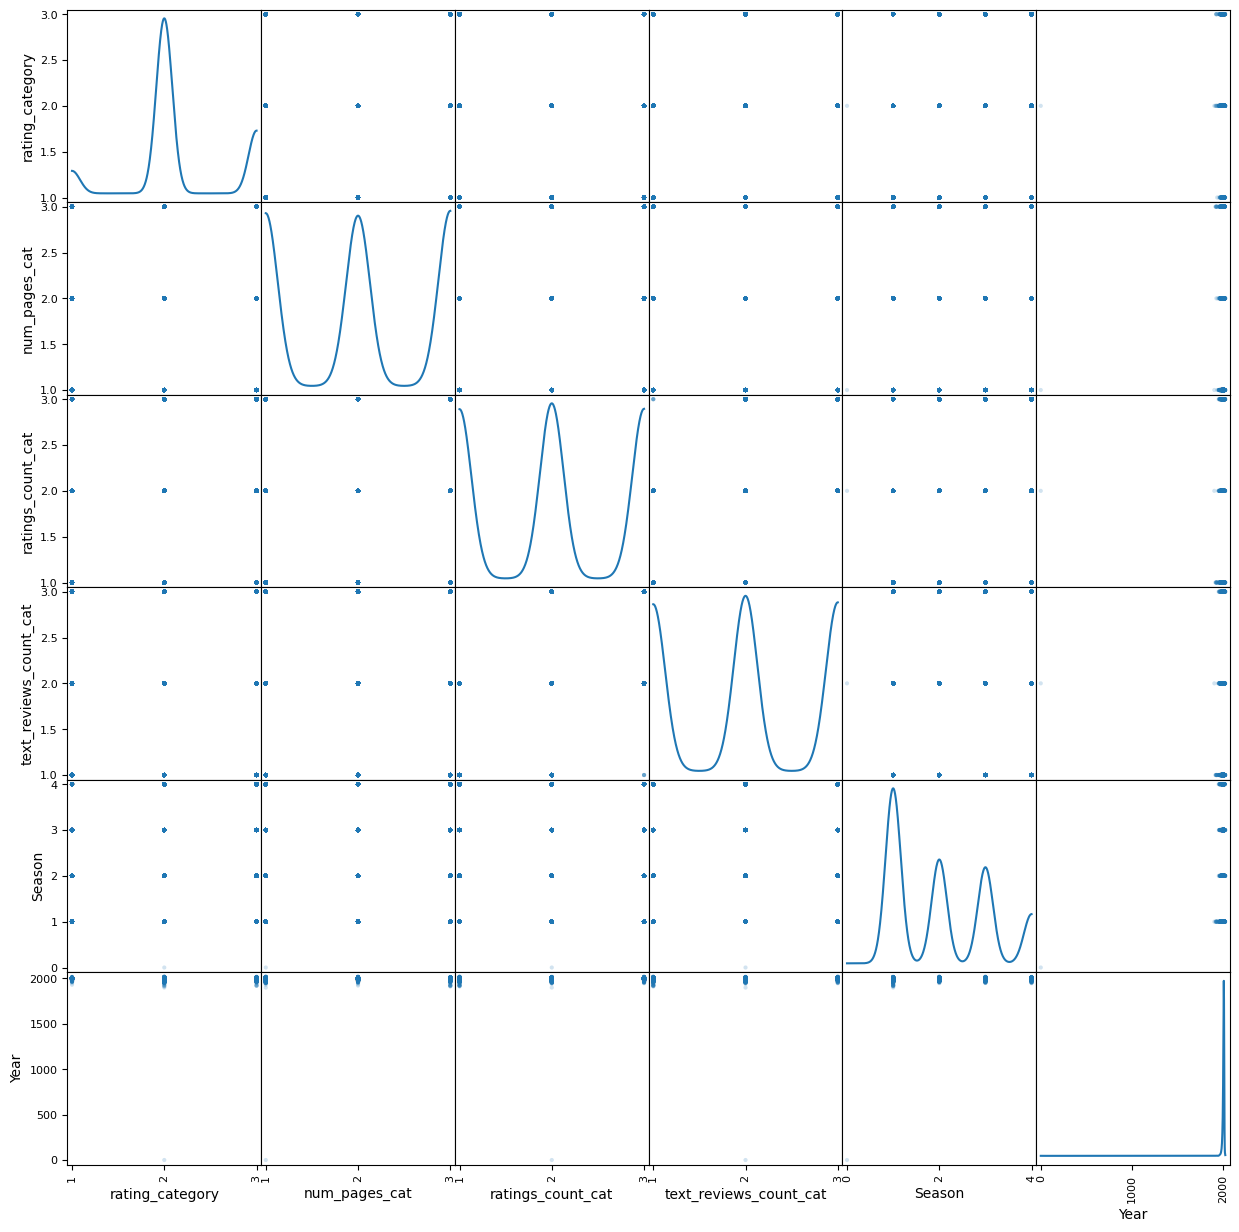

In [ ]:
# If you are familiar with PDE, you can estimate each variable distribution with 'kde' method
scatter_matrix(cleaned_data, alpha=0.2, figsize=(15, 15), diagonal='kde')

array([[<AxesSubplot: xlabel='average_rating', ylabel='average_rating'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='average_rating'>,
        <AxesSubplot: xlabel='ratings_count', ylabel='average_rating'>,
        <AxesSubplot: xlabel='text_reviews_count', ylabel='average_rating'>],
       [<AxesSubplot: xlabel='average_rating', ylabel='  num_pages'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='  num_pages'>,
        <AxesSubplot: xlabel='ratings_count', ylabel='  num_pages'>,
        <AxesSubplot: xlabel='text_reviews_count', ylabel='  num_pages'>],
       [<AxesSubplot: xlabel='average_rating', ylabel='ratings_count'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='ratings_count'>,
        <AxesSubplot: xlabel='ratings_count', ylabel='ratings_count'>,
        <AxesSubplot: xlabel='text_reviews_count', ylabel='ratings_count'>],
       [<AxesSubplot: xlabel='average_rating', ylabel='text_reviews_count'>,
        <AxesSubplot: xlabel='  num_pages', ylabel='text_rev

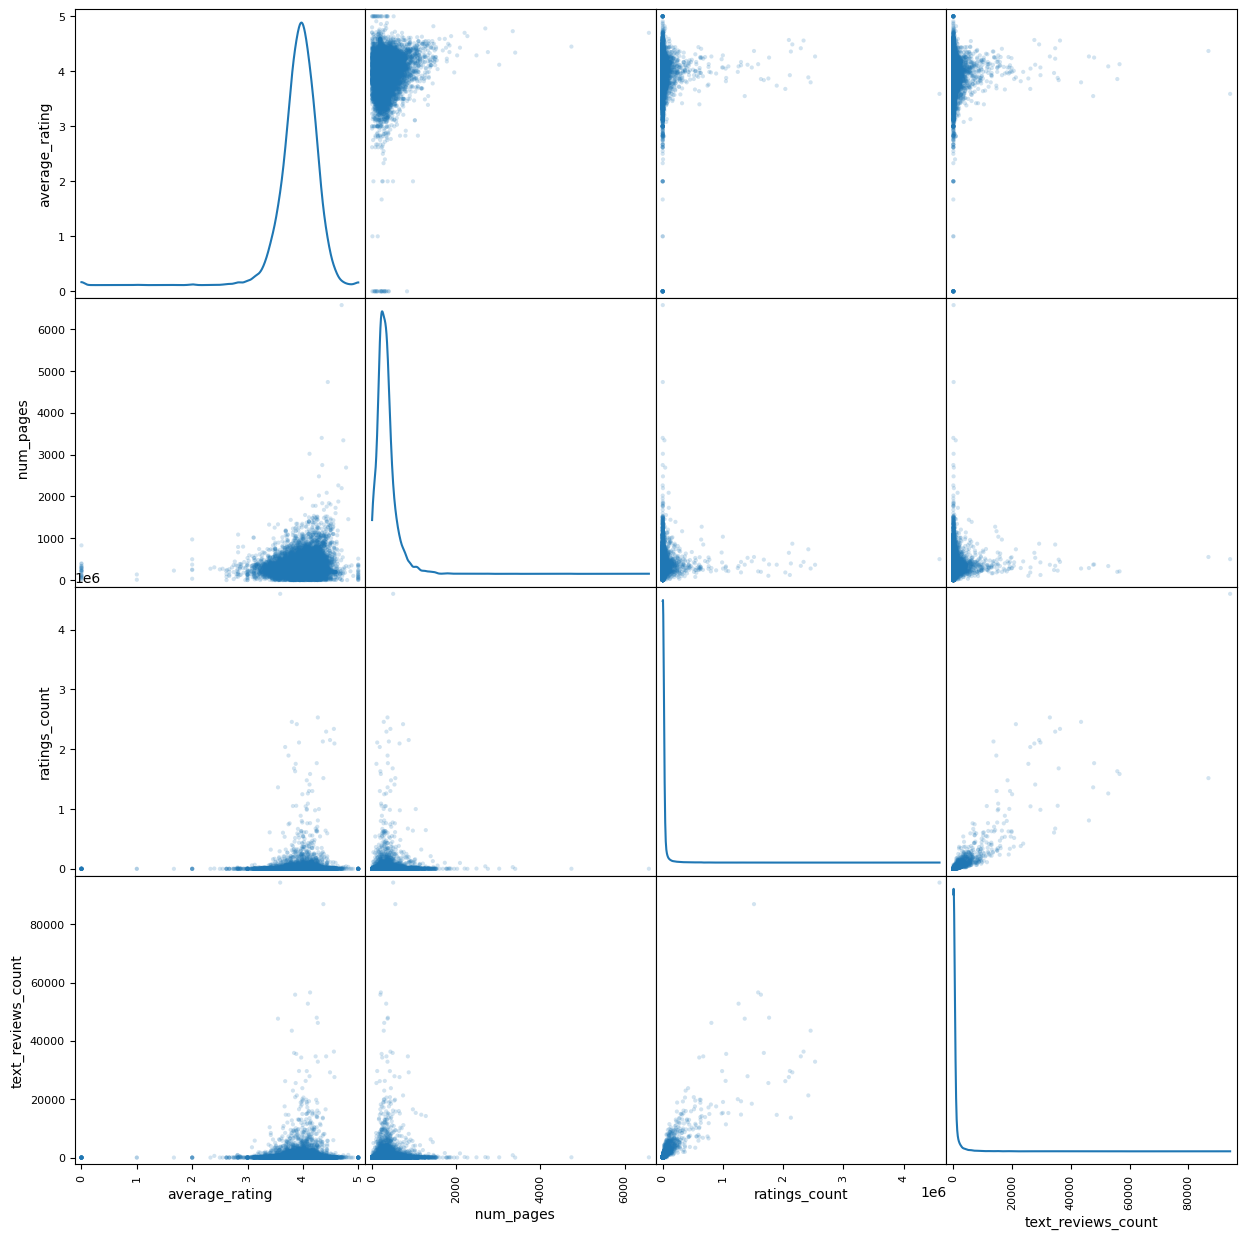

In [ ]:
# If you are familiar with PDE, you can estimate each variable distribution with 'kde' method
scatter_matrix(ori_data, alpha=0.2, figsize=(15, 15), diagonal='kde')

C:\Users\diego\AppData\Local\Temp\ipykernel_15292\355179016.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(cleaned_data.corr(),annot=True)


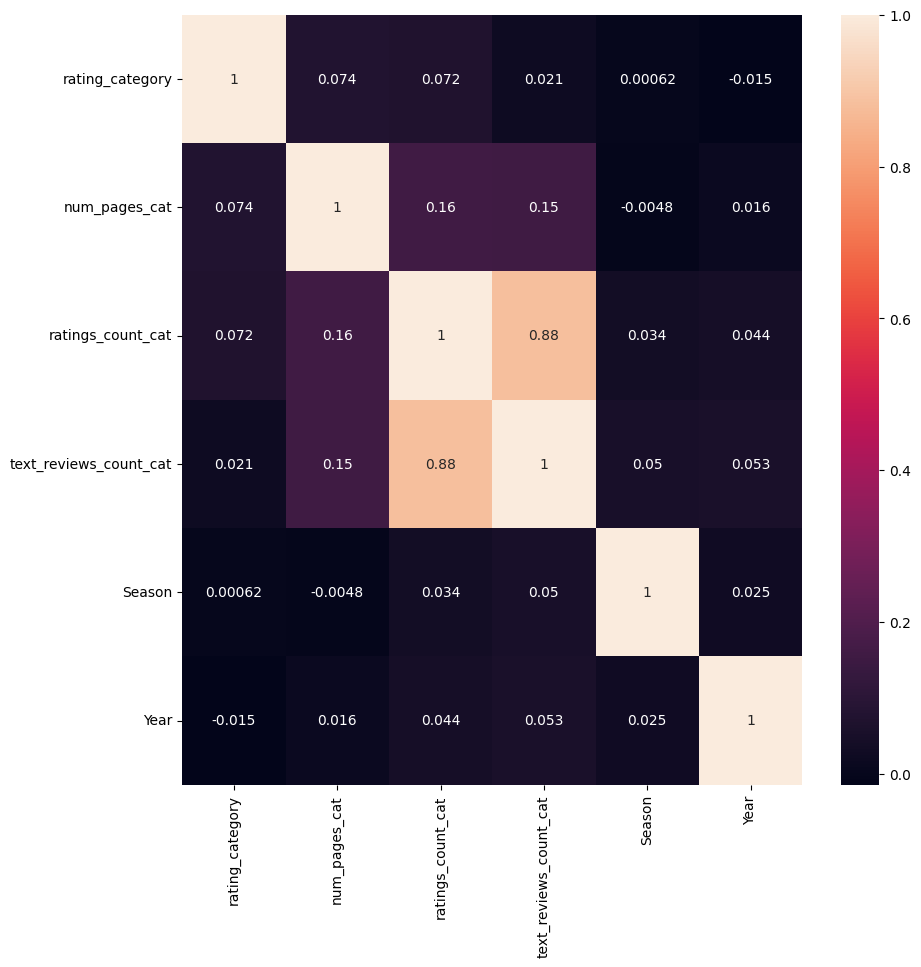

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(cleaned_data.corr(),annot=True)
plt.show()

C:\Users\diego\AppData\Local\Temp\ipykernel_15292\3876334148.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(ori_data.corr(),annot=True)


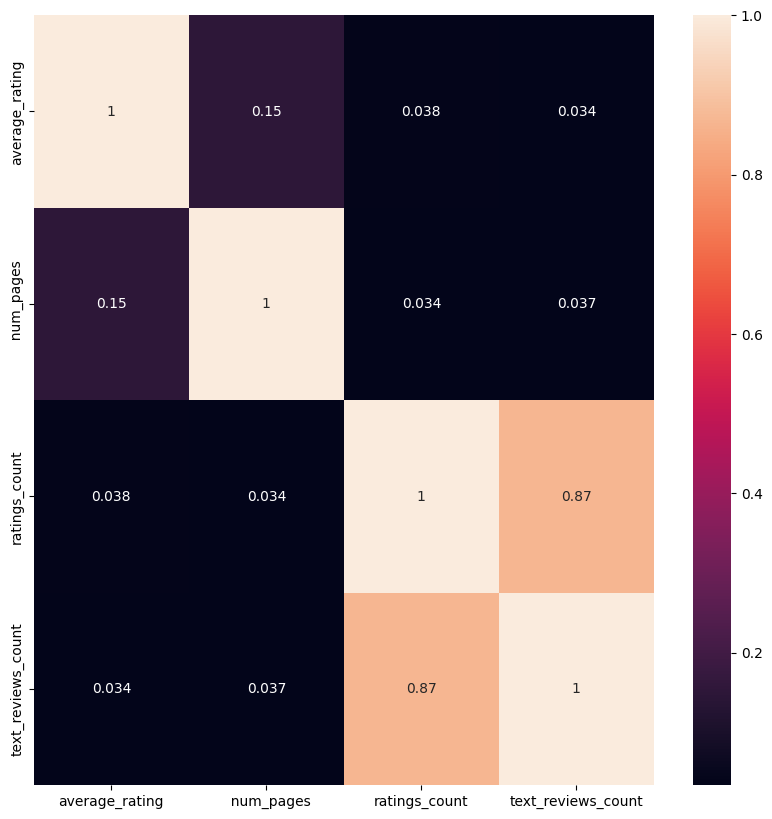

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(ori_data.corr(),annot=True)
plt.show()

## Setting a target

For our project we wanted to tackle the problem of predicting the ratings the average ratings of a book from the other parameters we have taken

In [ ]:
cleaned_data

,isbn,rating_category,num_pages_cat,ratings_count_cat,text_reviews_count_cat,Season,Year
0,0316015849,2,3,3,3,4,2006
1,0618260307,3,2,3,3,3,2002
2,0316769177,2,2,3,3,1,2001
3,1416524797,2,3,3,3,2,2006
4,043965548X,3,3,3,3,2,2004
...,...,...,...,...,...,...,...
10310,088684049X,1,1,1,1,1,1985
10311,0415940478,1,3,1,1,1,2002
10312,0340774770,1,1,1,1,2,2000
10313,8644101277,1,1,1,1,1,1996


In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(featured_eng_dataset,test_size = 0.2)
display(len(featured_eng_dataset))
display(len(df_train))
display(len(df_test))

10311

8248

2063

In [ ]:
display(featured_eng_dataset.describe())
display(df_train.describe())
display(df_test.describe())

,average_rating,num_pages,ratings_count,text_reviews_count,Year,rat_cat_1,rat_cat_2,rat_cat_3,np_cat_1,np_cat_2,...,rcount_cat_1,rcount_cat_2,rcount_cat_3,tr_count_1,tr_count_2,tr_count_3,season_1,season_2,season_3,season_4
count,10311.000000,10311.000000,1.031100e+04,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,...,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000,10311.000000
mean,3.933302,334.382698,1.926855e+04,578.359616,2000.214819,0.086316,0.672583,0.241102,0.333139,0.328775,...,0.329260,0.340607,0.330133,0.326641,0.342935,0.330424,0.412666,0.244593,0.226651,0.116090
std,0.357353,238.634519,1.167088e+05,2671.914308,8.157561,0.280843,0.469294,0.427773,0.471359,0.469791,...,0.469967,0.473936,0.470284,0.469008,0.474713,0.470389,0.492338,0.429867,0.418685,0.320348
min,0.000000,0.000000,0.000000e+00,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.770000,194.000000,1.120000e+02,9.000000,1998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,296.000000,8.660000e+02,51.000000,2003.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,410.500000,5.765500e+03,263.500000,2005.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,6576.000000,4.597666e+06,94265.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,average_rating,num_pages,ratings_count,text_reviews_count,Year,rat_cat_1,rat_cat_2,rat_cat_3,np_cat_1,np_cat_2,...,rcount_cat_1,rcount_cat_2,rcount_cat_3,tr_count_1,tr_count_2,tr_count_3,season_1,season_2,season_3,season_4
count,8248.000000,8248.000000,8.248000e+03,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,...,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000,8248.000000
mean,3.933883,335.902764,1.737297e+04,545.397793,2000.232784,0.086081,0.671799,0.242119,0.332081,0.329292,...,0.331717,0.337051,0.331232,0.328686,0.340204,0.331111,0.408584,0.247939,0.228661,0.114816
std,0.354345,242.348751,9.827733e+04,2394.883882,8.074071,0.280501,0.469587,0.428392,0.470988,0.469985,...,0.470858,0.472731,0.470685,0.469764,0.473806,0.470641,0.491602,0.431842,0.419996,0.318819
min,0.000000,0.000000,0.000000e+00,0.000000,1913.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.770000,196.000000,1.110000e+02,9.000000,1998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,296.000000,8.495000e+02,51.000000,2003.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,413.000000,5.764250e+03,261.000000,2005.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,6576.000000,2.530894e+06,86881.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,average_rating,num_pages,ratings_count,text_reviews_count,Year,rat_cat_1,rat_cat_2,rat_cat_3,np_cat_1,np_cat_2,...,rcount_cat_1,rcount_cat_2,rcount_cat_3,tr_count_1,tr_count_2,tr_count_3,season_1,season_2,season_3,season_4
count,2063.000000,2063.000000,2.063000e+03,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,...,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000,2063.000000
mean,3.930979,328.305381,2.684722e+04,710.142996,2000.142996,0.087252,0.675715,0.237033,0.337373,0.326709,...,0.319438,0.354823,0.325739,0.318468,0.353854,0.327678,0.428987,0.231217,0.218614,0.121183
std,0.369212,223.120571,1.714753e+05,3568.587312,8.484790,0.282272,0.468221,0.425366,0.472928,0.469123,...,0.466372,0.478576,0.468764,0.465995,0.478280,0.469481,0.495051,0.421713,0.413406,0.326419
min,0.000000,0.000000,0.000000e+00,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.770000,192.000000,1.170000e+02,10.000000,1998.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,296.000000,9.140000e+02,51.000000,2003.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.130000,406.000000,5.772000e+03,272.500000,2005.000000,0.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,5.000000,2690.000000,4.597666e+06,94265.000000,2019.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_train

,isbn,average_rating,num_pages,ratings_count,text_reviews_count,Year,rat_cat_1,rat_cat_2,rat_cat_3,np_cat_1,...,rcount_cat_1,rcount_cat_2,rcount_cat_3,tr_count_1,tr_count_2,tr_count_3,season_1,season_2,season_3,season_4
10249,1581346522,4.19,268,4446,218,2004,0,0,1,0,...,0,0,1,0,0,1,0,0,0,1
4807,3473352349,3.38,153,2591,207,1999,1,0,0,1,...,0,1,0,0,0,1,0,1,0,0
4035,0375423001,3.75,276,7776,560,2006,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1
6864,1416546022,3.21,246,10304,1092,2007,1,0,0,0,...,0,0,1,0,0,1,0,1,0,0
2898,0679749047,3.91,336,3192,195,1996,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168,0142402931,3.98,324,60,9,2005,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
9182,0306810700,3.83,256,91,11,2001,0,1,0,0,...,1,0,0,1,0,0,0,0,0,1
4399,0393011836,3.86,320,3176,366,2002,0,1,0,0,...,0,0,1,0,0,1,0,1,0,0
8376,0756630525,4.33,160,945,17,2007,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0


In [ ]:
df_train.columns

Index(['isbn', 'average_rating', '  num_pages', 'ratings_count',
       'text_reviews_count', 'Year', 'rat_cat_1', 'rat_cat_2', 'rat_cat_3',
       'np_cat_1', 'np_cat_2', 'np_cat_3', 'rcount_cat_1', 'rcount_cat_2',
       'rcount_cat_3', 'tr_count_1', 'tr_count_2', 'tr_count_3', 'season_1',
       'season_2', 'season_3', 'season_4'],
      dtype='object')

In [ ]:
featured_eng_dataset.columns

Index(['isbn', 'average_rating', '  num_pages', 'ratings_count',
       'text_reviews_count', 'Year', 'rat_cat_1', 'rat_cat_2', 'rat_cat_3',
       'np_cat_1', 'np_cat_2', 'np_cat_3', 'rcount_cat_1', 'rcount_cat_2',
       'rcount_cat_3', 'tr_count_1', 'tr_count_2', 'tr_count_3', 'season_1',
       'season_2', 'season_3', 'season_4'],
      dtype='object')

In [ ]:
X_train = df_train.loc[:, ['  num_pages', 'ratings_count', 'text_reviews_count',
       'Year', 'rat_cat_1', 'rat_cat_2', 'rat_cat_3', 'np_cat_1', 'np_cat_2',
       'np_cat_3', 'rcount_cat_1', 'rcount_cat_2', 'rcount_cat_3',
       'tr_count_1', 'tr_count_2', 'tr_count_3', 'season_1', 'season_2',
       'season_3', 'season_4']].values
Y_train = df_train.average_rating.values

In [ ]:
X_test = df_test.loc[:, [ '  num_pages', 'ratings_count', 'text_reviews_count',
       'Year', 'rat_cat_1', 'rat_cat_2', 'rat_cat_3', 'np_cat_1', 'np_cat_2',
       'np_cat_3', 'rcount_cat_1', 'rcount_cat_2', 'rcount_cat_3',
       'tr_count_1', 'tr_count_2', 'tr_count_3', 'season_1', 'season_2',
       'season_3', 'season_4']].values
Y_test = df_test.average_rating.values

## Algorithms to Choose

For Prediction of a variable

1. Ordinary Least Squares (Classic way of fitting data with a linear model) - BEST
2. Polynomial Regression (If linear model is not good enough, a polynomial could reduce)
3. Elastic Net (Linear Model that takes into account features of both Lasso and Ridge Regressions)
4. Bayesian Regression (It uses random variables to obtain a fully probabilistic model, where the output is assumed to be Gaussian distributed around Xw)
5. Stochastic Gradient Descent - SGD (Stochastic Gradient is useful when the number of features and samples is large)

For Classification Purposes:

1. Gaussian Naive Bayes
2. Logistic Regression
3. AdaBoost
4. Random Forest

## Ordinary Least Squares

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

# Make predictions using the testing set
Y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))


"""# Plot outputs
plt.scatter(X_test, Y_test, color="black")
plt.plot(X_test, Y_pred, color="blue", linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()"""

Coefficients: 
 [ 6.83655508e-05  2.42060745e-08 -1.82962047e-07  7.99533230e-05
 -5.59117376e-01  7.88382759e-02  4.80279100e-01  1.37704004e-02
 -1.21742801e-02 -1.59612032e-03 -2.08503797e-02  3.18922536e-03
  1.76611544e-02  1.45678355e-03  6.78522751e-03 -8.24201106e-03
  2.93978100e-03 -5.90274526e-03 -5.73180692e-03  8.69477118e-03]
Mean squared error: 0.06
Coefficient of determination: 0.57


'# Plot outputs\nplt.scatter(X_test, Y_test, color="black")\nplt.plot(X_test, Y_pred, color="blue", linewidth=3)\n\nplt.xticks(())\nplt.yticks(())\n\nplt.show()'

In [ ]:
from sklearn.linear_model import ElasticNet
alpha = 0.1
enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, Y_train).predict(X_test)
r2_score_enet = r2_score(Y_test, y_pred_enet)
print(enet)
print("r^2 on test data : %f" % r2_score_enet)

ElasticNet(alpha=0.1, l1_ratio=0.7)
r^2 on test data : 0.105466


In [ ]:
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

y_pred_lasso = lasso.fit(X_train, Y_train).predict(X_test)
r2_score_lasso = r2_score(Y_test, y_pred_lasso)
print(lasso)
print("r^2 on test data : %f" % r2_score_lasso)

Lasso(alpha=0.1)
r^2 on test data : 0.023661


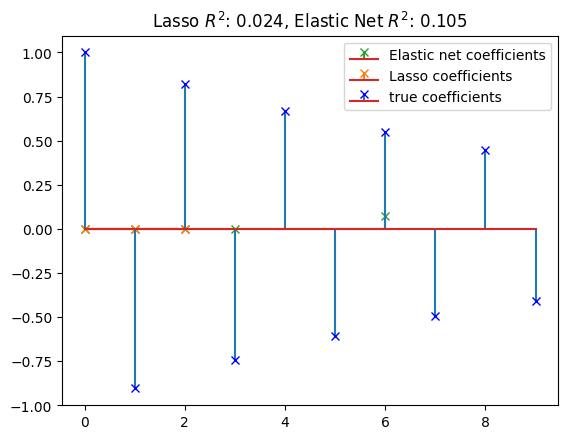

In [ ]:
import numpy as np
idx = np.arange(20)
coef = (-1) ** idx * np.exp(-idx / 10)
coef[10:] = 0  # sparsify coef

m, s, _ = plt.stem(
    np.where(enet.coef_)[0],
    enet.coef_[enet.coef_ != 0],
    markerfmt="x",
    label="Elastic net coefficients",
)
plt.setp([m, s], color="#2ca02c")
m, s, _ = plt.stem(
    np.where(lasso.coef_)[0],
    lasso.coef_[lasso.coef_ != 0],
    markerfmt="x",
    label="Lasso coefficients",
)
plt.setp([m, s], color="#ff7f0e")
plt.stem(
    np.where(coef)[0],
    coef[coef != 0],
    label="true coefficients",
    markerfmt="bx",
)

plt.legend(loc="best")
plt.title(
    "Lasso $R^2$: %.3f, Elastic Net $R^2$: %.3f" % (r2_score_lasso, r2_score_enet)
)
plt.show()

In [ ]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
Y_pred = reg.fit(X_train, Y_train).predict(X_test)
reg.coef_
# The coefficients
print("Coefficients: \n",reg.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

Coefficients: 
 [ 7.00438055e-05  2.76927492e-08 -4.53990344e-07  1.56377742e-03
 -4.20544011e-01  2.18121045e-01  6.20137073e-01  1.53364338e-01
  1.26819494e-01  1.37530274e-01  1.18434658e-01  1.42294419e-01
  1.56985030e-01  1.42553182e-01  1.46490938e-01  1.28669987e-01
  1.07644800e-01  9.80293347e-02  9.87345775e-02  1.13305394e-01]
Mean squared error: 0.06
Coefficient of determination: 0.56


In [ ]:
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Always scale the input. The most convenient way is to use a pipeline.
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
Y_pred = reg.fit(X_train, Y_train).predict(X_test)
# The coefficients
# print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))


Mean squared error: 0.06
Coefficient of determination: 0.56


## Classification

1. Gaussian Naive Bayes
2. Logistic Regression
3. AdaBoost
4. Random Forest

In [ ]:
featured_eng_dataset

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(featured_eng_dataset,test_size = 0.2)
display(len(featured_eng_dataset))
display(len(df_train))
display(len(df_test))

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
iris = load_iris()
cross_val_score(clf, iris.data, iris.target, cv=10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                           random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

print(clf.predict([[0, 0, 0, 0]]))

In [ ]:
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

X, y = load_iris(return_X_y=True)
clf = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

In [ ]:
random_forrest.fit(X=X_train_prepared,y=y_train)
adaboost.fit(X=X_train_prepared,y=y_train)
decision_tree.fit(X=X_train_prepared,y=y_train)
linear_regression.fit(X=X_train_prepared,y=y_train)

y_test_pred_random_forrest = random_forrest.predict(X_test_prepared)
y_test_pred_adaboost = adaboost.predict(X_test_prepared)
y_test_pred_decision_tree= decision_tree.predict(X_test_prepared)
y_test_pred_linear_regression = linear_regression.predict(X_test_prepared)

from sklearn.metrics import mean_absolute_error, max_error, explained_variance_score

print("linear_regression")
mean_absolute_error(y_pred=y_test_pred_linear_regression,y_true=y_test)
print("decision_tree")
mean_absolute_error(y_pred=y_test_pred_decision_tree,y_true=y_test)
print("random_forrest")
mean_absolute_error(y_pred=y_test_pred_random_forrest,y_true=y_test)
print("adaboost")
mean_absolute_error(y_pred=y_test_pred_adaboost,y_true=y_test)

## Unsupervised Learning

1. K-means (General-purpose, even cluster size, flat geometry, not too many )
2. DBSCAN (Non-flat Geometry, uneven cluster sizes, outilser removal, transductive)

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array([[1, 2], [1, 4], [1, 0],
              [10, 2], [10, 4], [10, 0]])
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_

kmeans.predict([[0, 0], [12, 3]])

kmeans.cluster_centers_


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
X = np.array([[1, 2], [2, 2], [2, 3],
              [8, 7], [8, 8], [25, 80]])
clustering = DBSCAN(eps=3, min_samples=2).fit(X)
clustering.labels_

clustering


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
clf.predict(X_test[:2, :])
y_pred = clf.predict(X_test)
print(y_pred.dtype)
print(y_test.dtype)

score = clf.score(X_test, y_test) # accuracy of the model
print(score)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [ ]:
<img src="cm.png" style="width:500px;height:300;">

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

In [ ]:
fig, ax = plt.subplots()
plot_confusion_matrix(cm, classes=np.unique(y), ax = ax)

In [ ]:
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
KNeighborsClassifier)
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

nca = NeighborhoodComponentsAnalysis(random_state=42)
knn = KNeighborsClassifier(n_neighbors=4)
nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
nca_pipe.fit(X_train, y_train)

print(nca_pipe.score(X_test, y_test))


y_pred_knc = nca_pipe.predict(X_test)
cm_knc = confusion_matrix(y_test, y_pred_knc)
fig1, ax1 = plt.subplots()
plot_confusion_matrix(cm_knc, classes=np.unique(y), ax = ax1)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
"""X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)"""
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d"
      % (X_test.shape[0], (y_test != y_pred).sum()))
print('Score : ',gnb.score(X_test,y_test))

print(nca_pipe.score(X_test, y_test))


y_pred_gnb = gnb.predict(X_test)
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
fig2, ax2 = plt.subplots()
plot_confusion_matrix(cm_gnb, classes=np.unique(y), ax = ax2)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=2, random_state=0)
r.fit(X_train, y_train)
print(rf.predict(X_test[:2, :]))

In [ ]:
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.inspection import DecisionBoundaryDisplay


"""# import some data to play with
iris = datasets.load_iris()
# Take the first two features. We could avoid this by using a two-dim dataset
X = iris.data[:, :2]
y = iris.target"""

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (
    svm.SVC(kernel="linear", C=C),
    svm.LinearSVC(C=C, max_iter=10000),
    svm.SVC(kernel="rbf", gamma=0.7, C=C),
    svm.SVC(kernel="poly", degree=3, gamma="auto", C=C),
)
models = (clf.fit(X, y) for clf in models)

# title for the plots
titles = (
    "SVC with linear kernel",
    "LinearSVC (linear kernel)",
    "SVC with RBF kernel",
    "SVC with polynomial (degree 3) kernel",
)

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors="k")
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [ ]:
accuracy : 
    is not the best metric ever,
    there methods that can allow you have better accuracy
    number of corrections / number of 
 
you can change for instance, age can be transform into quality category

Standard Scaler: interesting for preprocessing

You can resample your dataset, there is a resample method in scikit learn to overrepresent, underrepresent

we can perform a pipeline to define 5 to 10 algorithms to test on the same data transformation (sklearn.pipeline.Pipeline)
Depending on the data distribution there are algorithms that could work better

Extra test on ranges

Inferential statistics allows you to see which parameters allow you see which parameters is of value

During Training => you use work on parameters to choose and the robusteness
Then Inference allows you feedback loops => ML Ops

In [ ]:
from sklearn.metrics import confusion_matrix
cf = pd.DataFrame(
    columns=["y_test_0","y_test_1"],index=["y_pred_0","y_pred_1"]
)
cf.loc[:,:] = confusion_matrix(y_true= y_test,y_pred= y_test_predicted)
cf
cf/len(y_test)

In [ ]:
from sklearn.metrics import recall_score, precision_score
recall_score(y_true=y_test, y_pred=y_test_predicted)
precision_score(y_true=y_test, y_pred=y_test_predicted)

In [ ]:
from sklearn.metrics import classification_report
report =classification_report(y_true=y_test, y_pred=y_test_predicted)
print(report)

In [ ]:
from sklearn.neural_network import MLPClassifier
nn_model.fit(X=X_train,y=y_train)
y_test_predicted_nn = nn_model.predict(X_test)
report_nn = classification_report(y_pred=y_test_predicted_nn,y_true=y_test)
print(report_nn)